# Data Preparation

## Library Imports

In [35]:
# Standard Library
import json
import math
import os

# Third-Party Data & Numerical Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Interactive Display & Widgets
from IPython.display import display, clear_output
from ipywidgets import interact, widgets

# Machine Learning
from sklearn.linear_model import LinearRegression


# from google.colab import drive
# drive.mount('/content/drive')

## Data Ingestion, Cleaning & Processing

In [36]:
# This cell converts the raw ocean csv to lines where the varaibles of interest are and then into an unformatted dataframe

# file_path_raw = '/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 696/Data/ocean_test_2.csv' # Google Colab Path to Sample of the raw Ocean data
file_path_raw = 'Data/ocean_test_2.csv' # Local Path to Sample of the raw Ocean data

separator = "#--------------------------------------------------------------------------------"
starts = ('CAST', 'Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Time', 'Country', 'Bottom depth', 'VARIABLES', ' ')

lines=[]
if os.path.exists(file_path_raw):
    with open(file_path_raw, 'r') as f:
        for line in f:
            if line.startswith(starts):
                lines.append(line.strip())
    split_values = [x.split(',') for x in lines]

    clean_values=[[x.strip() for x in lin] for lin in split_values]

    ocean_df=pd.DataFrame(clean_values)
else:
    print(f"Error: File not found at {file_path_raw}")
    ocean_df = pd.DataFrame() # Create an empty DataFrame to avoid NameError later

In [37]:
ocean_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,CAST,,16493420,WOD Unique Cast Number,WOD code,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Latitude,,54.207,decimal degrees,,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Longitude,,13.567,decimal degrees,,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Year,,2000,,,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Month,,1,,,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,Day,,3,,,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,Time,,10.72,decimal hours (UT),,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,Country,,DE,NODC code,GERMANY,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,Bottom depth,,9.,meters,,,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,VARIABLES,Depth,F,O,Temperatur,F,O,Salinity,F,O,...,F,O,Chlorophyl,F,O,Pressure,F,O,,


In [38]:
# This cell takes the unformatted dataframe and converts it to a typical table structure

cast_idx = ocean_df.index[ocean_df[0] == 'CAST'].to_list()
variable_idx = ocean_df.index[ocean_df[0] == 'VARIABLES'].to_list()

clean_parts = []
n_cast = len(cast_idx)
for i, c_start in enumerate(cast_idx):
    c_end = cast_idx[i+1] if i+1 < n_cast else len(ocean_df)
    block = ocean_df.iloc[c_start:c_end]
    cast_info_t = block.T.dropna()
    if not cast_info_t.empty:
        cast_info_t.columns = cast_info_t.iloc[0]
        meta = cast_info_t.loc[:, cast_info_t.columns.intersection(starts[:9])]
        meta = meta.drop(index=[x for x in [0,1,3,4] if x in meta.index], errors='ignore').reset_index(drop=True)
    else:
        meta = pd.DataFrame()
    var_candidates = [v for v in variable_idx if c_start <= v < c_end]
    if var_candidates:
        v_start = var_candidates[0]
        variable_chunk = ocean_df.iloc[v_start:c_end].dropna(axis=1)
        header = variable_chunk.iloc[0]
        variable_chunk = variable_chunk.iloc[1:].copy()
        variable_chunk.columns = header
        variable_chunk = variable_chunk.drop(columns=[c for c in ['VARIABLES','F','O'] if c in variable_chunk.columns], errors='ignore').reset_index(drop=True)
    else:
        variable_chunk = pd.DataFrame()
    if meta.empty and variable_chunk.empty:
        continue
    if not meta.empty and not variable_chunk.empty and len(meta)==1 and len(variable_chunk)>1:
        meta = pd.concat([meta]*len(variable_chunk), ignore_index=True)
    combined = pd.concat([meta.reset_index(drop=True), variable_chunk.reset_index(drop=True)], axis=1).ffill()
    clean_parts.append(combined)

clean_ocean = pd.concat(clean_parts, ignore_index=True) if clean_parts else pd.DataFrame()
clean_ocean = clean_ocean.drop('', axis=1)
clean_ocean.replace(to_replace='---*---', value=np.nan, inplace=True)

In [39]:
clean_ocean.head(10)

,CAST,Latitude,Longitude,Year,Month,Day,Time,Country,Bottom depth,Depth,Temperatur,Salinity,Oxygen,Phosphate,Silicate,Nitrate,pH,Chlorophyl,Pressure
0,16493420,54.207,13.567,2000,1,3,10.72,DE,9.,1.5,2.5,7.4,403.,0.53,27.3,9.7,7.9,2.9,1.5
1,16493421,54.007,14.233,2000,1,3,13.68,DE,11.,1.5,2.1,7.1,406.,1.15,30.3,18.2,7.8,1.7,1.5
2,16493422,53.938,14.225,2000,1,3,14.63,DE,7.,1.5,2.3,6.4,381.,1.43,32.9,20.2,7.7,NaN,1.5
3,16493423,54.113,14.117,2000,1,3,16.02,DE,14.,1.5,2.4,8.5,427.,0.70,20.9,10.0,7.9,NaN,1.5
4,9573800,-3.0000,-145.5667,2000,1,3,22.90,99,NaN,0.0,24.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9573800,-3.0000,-145.5667,2000,1,3,22.90,99,NaN,100.0,24.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9573800,-3.0000,-145.5667,2000,1,3,22.90,99,NaN,132.0,24.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9573800,-3.0000,-145.5667,2000,1,3,22.90,99,NaN,145.0,23.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9573800,-3.0000,-145.5667,2000,1,3,22.90,99,NaN,149.0,22.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9573800,-3.0000,-145.5667,2000,1,3,22.90,99,NaN,157.0,16.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Overview

In [40]:
# file_path_formatted = '/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 696/Data/clean_ocean.csv' # Google Colab Path to Ocean data formatted
file_path_formatted = 'Data/clean_ocean.csv' # Local Path to Ocean data formatted

df = pd.read_csv(file_path_formatted)
df = df.rename(columns={'Temperatur': 'Temperature'})

df.head()

/var/folders/fz/xr7gzrtd5j12jcx7xtyjgyn00000gn/T/ipykernel_26756/3563176758.py:4: DtypeWarning:

Columns (17,18,19,21,22) have mixed types. Specify dtype option on import or set low_memory=False.



,CAST,Latitude,Longitude,Year,Month,Day,Time,Country,Bottom depth,Depth,...,tCO2,Alkalinity,CFC11,CFC12,CFC113,Tritium,Helium,Neon,pCO2,Argon
0,16493420,54.207,13.5670,2000,1,3,10.72,DE,9.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16493421,54.007,14.2330,2000,1,3,13.68,DE,11.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16493422,53.938,14.2250,2000,1,3,14.63,DE,7.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16493423,54.113,14.1170,2000,1,3,16.02,DE,14.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9573800,-3.000,-145.5667,2000,1,3,22.90,99,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Examine the dataset structure including columns, data types, and non-null values
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946802 entries, 0 to 1946801
Data columns (total 29 columns):
 #   Column        Dtype  
---  ------        -----  
 0   CAST          int64  
 1   Latitude      float64
 2   Longitude     float64
 3   Year          int64  
 4   Month         int64  
 5   Day           int64  
 6   Time          float64
 7   Country       object 
 8   Bottom depth  float64
 9   Depth         float64
 10  Temperature   float64
 11  Salinity      float64
 12  Oxygen        float64
 13  Phosphate     float64
 14  Silicate      float64
 15  Nitrate       float64
 16  pH            float64
 17  Chlorophyl    object 
 18  Pressure      object 
 19  tCO2          object 
 20  Alkalinity    float64
 21  CFC11         object 
 22  CFC12         object 
 23  CFC113        float64
 24  Tritium       float64
 25  Helium        float64
 26  Neon          float64
 27  pCO2          float64
 28  Argon         float64
dtypes: float64(19), int64(4), obje

In [42]:
# Convert object columns to numeric
columns = ['Chlorophyl', 'Pressure', 'tCO2', 'CFC11', 'CFC12']

for col in columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    print(f"{col} converted to {df[col].dtype}")

# Verify the conversion worked
print("\nAfter conversion:")
print(df[columns].dtypes)

Chlorophyl converted to float64
Pressure converted to float64
tCO2 converted to float64
CFC11 converted to float64
CFC12 converted to float64

After conversion:
Chlorophyl    float64
Pressure      float64
tCO2          float64
CFC11         float64
CFC12         float64
dtype: object


In [43]:
# Calculate and display the number of missing values in each column
print("\nMissing Values:")
# df.isnull().sum()  # Counts the number of null values in each column to identify data quality issues

missing_df = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2),
    'Remaining if Dropped': len(df) - df.isnull().sum()
})
print(missing_df)



Missing Values:
              Missing Count  Missing %  Remaining if Dropped
CAST                      0       0.00               1946802
Latitude                  0       0.00               1946802
Longitude                 0       0.00               1946802
Year                      0       0.00               1946802
Month                     0       0.00               1946802
Day                       0       0.00               1946802
Time                  68485       3.52               1878317
Country                   0       0.00               1946802
Bottom depth         361807      18.58               1584995
Depth                     0       0.00               1946802
Temperature          110092       5.66               1836710
Salinity             290953      14.95               1655849
Oxygen               653641      33.58               1293161
Phosphate            823888      42.32               1122914
Silicate             881219      45.26               1065583
Nitrate

In [44]:
# Count the number of unique values in each column to understand cardinality
print("\nUnique Values:")
df.nunique()  # Helps identify categorical variables and potential outliers


Unique Values:


CAST            212642
Latitude         73363
Longitude        83696
Year                19
Month               12
Day                 31
Time              5736
Country             32
Bottom depth      7640
Depth           222000
Temperature     227562
Salinity         97050
Oxygen           65287
Phosphate         6044
Silicate         29190
Nitrate          14767
pH               10193
Chlorophyl        9587
Pressure         61204
tCO2              9843
Alkalinity       16461
CFC11            15155
CFC12            11150
CFC113            3313
Tritium           1252
Helium            2850
Neon              2516
pCO2              4030
Argon              114
dtype: int64

## Missing Value Handling

In [45]:
df_processed = df.copy()
df_processed.head()

,CAST,Latitude,Longitude,Year,Month,Day,Time,Country,Bottom depth,Depth,...,tCO2,Alkalinity,CFC11,CFC12,CFC113,Tritium,Helium,Neon,pCO2,Argon
0,16493420,54.207,13.5670,2000,1,3,10.72,DE,9.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16493421,54.007,14.2330,2000,1,3,13.68,DE,11.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16493422,53.938,14.2250,2000,1,3,14.63,DE,7.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16493423,54.113,14.1170,2000,1,3,16.02,DE,14.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9573800,-3.000,-145.5667,2000,1,3,22.90,99,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Target Variable - Oxygen


**Observation:**
Oxygen, being the target variable in upcoming predictive ML tasks, should not be imputed as this could introduce uncertainty, error and data leakage.

In [46]:
# Remove rows where Oxygen column has null/missing values
df_processed_1 = df_processed.dropna(subset=['Oxygen'])

# Check the results
print(f"Original dataset: {len(df_processed):,} rows")
print(f"After removing missing oxygen: {len(df_processed_1):,} rows")
print(f"Rows removed: {len(df_processed) - len(df_processed_1):,}")

Original dataset: 1,946,802 rows
After removing missing oxygen: 1,293,161 rows
Rows removed: 653,641


In [47]:
# Calculate and display the number of missing values in each column
print("\nMissing Values:")
# df.isnull().sum()  # Counts the number of null values in each column to identify data quality issues

missing_df = pd.DataFrame({
    'Missing Count': df_processed_1.isnull().sum(),
    'Missing %': (df_processed_1.isnull().sum() / len(df_processed_1) * 100).round(2),
    'Remaining if Dropped': len(df_processed_1) - df_processed_1.isnull().sum()
})
print(missing_df)


Missing Values:
              Missing Count  Missing %  Remaining if Dropped
CAST                      0       0.00               1293161
Latitude                  0       0.00               1293161
Longitude                 0       0.00               1293161
Year                      0       0.00               1293161
Month                     0       0.00               1293161
Day                       0       0.00               1293161
Time                  41499       3.21               1251662
Country                   0       0.00               1293161
Bottom depth         127292       9.84               1165869
Depth                     0       0.00               1293161
Temperature           30308       2.34               1262853
Salinity             116589       9.02               1176572
Oxygen                    0       0.00               1293161
Phosphate            289326      22.37               1003835
Silicate             338852      26.20                954309
Nitrate

### High Correlation Regression Imputation - Pressure

**Observation:**
Depth and Pressure have a nearly perfect linearly correlated relationship, making them suitable for regression imputation.

Correlation between Depth and Pressure: 1.0000


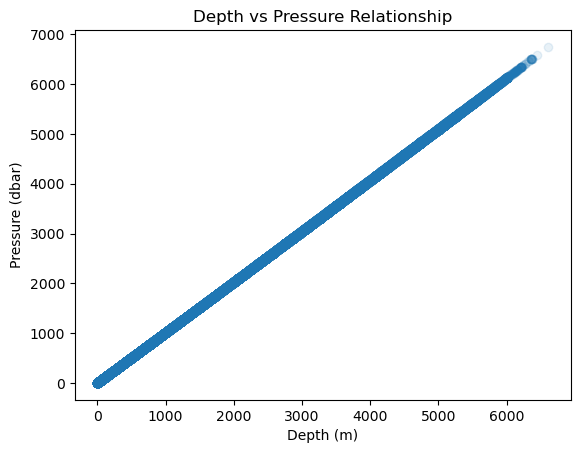

In [48]:
# Check correlation between depth and pressure where both exist
both_exist = df_processed_1[df_processed_1['Pressure'].notna() & df_processed_1['Depth'].notna()]
correlation = both_exist['Depth'].corr(both_exist['Pressure'])
print(f"Correlation between Depth and Pressure: {correlation:.4f}")

# Visualize the relationship
plt.scatter(both_exist['Depth'], both_exist['Pressure'], alpha=0.1)
plt.xlabel('Depth (m)')
plt.ylabel('Pressure (dbar)')
plt.title('Depth vs Pressure Relationship')
plt.show()

In [49]:
# Impute missing pressure values from highly correlated variable depth

# Get rows where both depth and pressure exist for training
df_processed_2 = df_processed_1.copy()
both_exist = df_processed_2[df_processed_2['Pressure'].notna() & df_processed_2['Depth'].notna()]

# Fit regression model
model = LinearRegression()
model.fit(both_exist[['Depth']], both_exist['Pressure'])

print("BEFORE IMPUTATION:")
print(f"Correlation: {both_exist['Depth'].corr(both_exist['Pressure']):.6f}")
print(f"Slope: {model.coef_[0]:.6f}")
print(f"Intercept: {model.intercept_:.6f}")

# Identify rows with missing pressure but available depth
missing_pressure = df_processed_2['Pressure'].isna() & df_processed_2['Depth'].notna()

# Impute missing pressure values
df_processed_2.loc[missing_pressure, 'Pressure'] = model.predict(df_processed_2.loc[missing_pressure, ['Depth']])

print(f"\nImputed {missing_pressure.sum():,} pressure values")

# Validate: Check relationship after imputation
all_data = df_processed_2[df_processed_2['Pressure'].notna() & df_processed_2['Depth'].notna()]
new_correlation = all_data['Depth'].corr(all_data['Pressure'])

model_check = LinearRegression()
model_check.fit(all_data[['Depth']], all_data['Pressure'])

print("\nAFTER IMPUTATION:")
print(f"Correlation: {new_correlation:.6f}")
print(f"Slope: {model_check.coef_[0]:.6f}")
print(f"Intercept: {model_check.intercept_:.6f}")
print(f"Remaining missing pressure: {df_processed_2['Pressure'].isna().sum():,}")

BEFORE IMPUTATION:
Correlation: 0.999994
Slope: 1.016787
Intercept: -2.775660

Imputed 480,345 pressure values

AFTER IMPUTATION:
Correlation: 0.999995
Slope: 1.016787
Intercept: -2.775660
Remaining missing pressure: 0


In [50]:
# Calculate and display the number of missing values in each column
print("\nMissing Values:")
# df.isnull().sum()  # Counts the number of null values in each column to identify data quality issues

missing_df = pd.DataFrame({
    'Missing Count': df_processed_2.isnull().sum(),
    'Missing %': (df_processed_2.isnull().sum() / len(df_processed_2) * 100).round(2),
    'Remaining if Dropped': len(df_processed_2) - df_processed_2.isnull().sum()
})
print(missing_df)


Missing Values:
              Missing Count  Missing %  Remaining if Dropped
CAST                      0       0.00               1293161
Latitude                  0       0.00               1293161
Longitude                 0       0.00               1293161
Year                      0       0.00               1293161
Month                     0       0.00               1293161
Day                       0       0.00               1293161
Time                  41499       3.21               1251662
Country                   0       0.00               1293161
Bottom depth         127292       9.84               1165869
Depth                     0       0.00               1293161
Temperature           30308       2.34               1262853
Salinity             116589       9.02               1176572
Oxygen                    0       0.00               1293161
Phosphate            289326      22.37               1003835
Silicate             338852      26.20                954309
Nitrate

### Columns with Severe Quality Issues

In [51]:
# Calculate missing percentage for each column
missing_percentages = (df_processed_2.isnull().sum() / len(df_processed_2)) * 100

# Identify columns with >70% missing values
high_missing_cols = missing_percentages[missing_percentages > 50].index.tolist()

# Print which columns will be dropped
print("Columns with Severe Quality Issues (>50% missing values): \n")
for col in high_missing_cols:
    print(f"{col}: {missing_percentages[col]:.2f}% missing")

Columns with Severe Quality Issues (>50% missing values): 

pH: 72.98% missing
Chlorophyl: 77.26% missing
tCO2: 79.52% missing
Alkalinity: 76.53% missing
CFC11: 84.81% missing
CFC12: 84.09% missing
CFC113: 91.48% missing
Tritium: 99.36% missing
Helium: 99.16% missing
Neon: 99.27% missing
pCO2: 99.58% missing
Argon: 99.99% missing


In [52]:
# Get correlation matrix for numeric columns only
numeric_cols = df_processed_2.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_processed_2[numeric_cols].corr()

correlation_analysis = []

for var in high_missing_cols:
    if var in correlation_matrix.columns:
        # Get correlations with all other variables
        var_corr = correlation_matrix[var].drop(var)  # Remove self-correlation

        # Sort by absolute correlation strength
        var_corr_sorted = var_corr.reindex(var_corr.abs().sort_values(ascending=False).index)

        # Get top correlations (above 0.3 threshold)
        strong_corr = var_corr_sorted[var_corr_sorted.abs() >= 0.3]

        correlation_analysis.append({
            'Variable': var,
            'Missing_Percent': f"{df_processed_2[var].isna().sum() / len(df_processed_2) * 100:.1f}%",
            'Strongest_Correlations': dict(strong_corr.head(5).round(3)),
            'Max_Abs_Correlation': round(var_corr_sorted.abs().max(), 3)  # Fixed: round() function instead of .round() method
        })

# Display results
for i, analysis in enumerate(correlation_analysis):
    print(f"\n=== {analysis['Variable']} ({analysis['Missing_Percent']} missing) ===")
    print(f"Maximum absolute correlation: {analysis['Max_Abs_Correlation']}")
    print("Strongest correlations (>0.3):")
    for predictor, corr_val in analysis['Strongest_Correlations'].items():
        predictor_missing = df_processed_2[predictor].isna().sum() / len(df_processed_2) * 100
        print(f"  {predictor}: {corr_val:5.3f} (predictor {predictor_missing:.1f}% missing)")


=== pH (73.0% missing) ===
Maximum absolute correlation: 0.916
Strongest correlations (>0.3):
  Argon: -0.916 (predictor 100.0% missing)
  pCO2: -0.895 (predictor 99.6% missing)
  tCO2: -0.872 (predictor 79.5% missing)
  Phosphate: -0.693 (predictor 22.4% missing)
  Tritium: 0.600 (predictor 99.4% missing)

=== Chlorophyl (77.3% missing) ===
Maximum absolute correlation: 0.564
Strongest correlations (>0.3):
  Helium: -0.564 (predictor 99.2% missing)
  Argon: -0.564 (predictor 100.0% missing)
  Tritium: 0.557 (predictor 99.4% missing)
  pH: 0.388 (predictor 73.0% missing)
  Salinity: -0.367 (predictor 9.0% missing)

=== tCO2 (79.5% missing) ===
Maximum absolute correlation: 0.9
Strongest correlations (>0.3):
  Nitrate: 0.900 (predictor 30.5% missing)
  Phosphate: 0.883 (predictor 22.4% missing)
  pH: -0.872 (predictor 73.0% missing)
  Argon: 0.860 (predictor 100.0% missing)
  Silicate: 0.838 (predictor 26.2% missing)

=== Alkalinity (76.5% missing) ===
Maximum absolute correlation: 0.6

**Observation:**
The extensively missing variables are heavily correlated with other extensively missing variables making them unsuitable for correlation-based imputation as a result of this circular dependency. Although some of also correlated with the taget variable oxygen, it is unwise to impute based on that correlated relationship as later during the ML tasks, these variables would be used to predict oxygen - thus creating abother circular dependency and potentially introducing error and/or data leakage into the predictions.

In [53]:
# Drop the high-missing columns
df_processed_3 = df_processed_2.drop(columns=high_missing_cols)

# Check the results
print(f"\nOriginal dataset: {len(df_processed_2):,} rows")
print(f"After removing missing oxygen: {len(df_processed_3):,} rows")
print(f"Rows removed: {len(df_processed_2) - len(df_processed_3):,}")

print(f"\nOriginal columns: {df_processed_2.shape[1]}")
print(f"Remaining columns: {df_processed_3.shape[1]}")
print(f"Columns dropped: {len(high_missing_cols)}")


Original dataset: 1,293,161 rows
After removing missing oxygen: 1,293,161 rows
Rows removed: 0

Original columns: 29
Remaining columns: 17
Columns dropped: 12


In [54]:
# Calculate and display the number of missing values in each column
print("\nMissing Values:")
# df.isnull().sum()  # Counts the number of null values in each column to identify data quality issues

missing_df = pd.DataFrame({
    'Missing Count': df_processed_3.isnull().sum(),
    'Missing %': (df_processed_3.isnull().sum() / len(df_processed_3) * 100).round(2),
    'Remaining if Dropped': len(df_processed_3) - df_processed_3.isnull().sum()
})
print(missing_df)


Missing Values:
              Missing Count  Missing %  Remaining if Dropped
CAST                      0       0.00               1293161
Latitude                  0       0.00               1293161
Longitude                 0       0.00               1293161
Year                      0       0.00               1293161
Month                     0       0.00               1293161
Day                       0       0.00               1293161
Time                  41499       3.21               1251662
Country                   0       0.00               1293161
Bottom depth         127292       9.84               1165869
Depth                     0       0.00               1293161
Temperature           30308       2.34               1262853
Salinity             116589       9.02               1176572
Oxygen                    0       0.00               1293161
Phosphate            289326      22.37               1003835
Silicate             338852      26.20                954309
Nitrate

### Incomplete Cast Imputation

In [55]:
# Analyze salvageable vs unsalvageable missing values
threshold = 0.5  # Casts need at least 50% data present to be salvageable
results = []
variables = [col for col in df_processed_3.columns if col != 'CAST' and df_processed_3[col].isnull().sum() > 0]

for variable in variables:
    # Total missing values for this variable
    total_missing = df_processed_3[variable].isnull().sum()

    # Calculate missing percentage per cast
    cast_stats = df_processed_3.groupby('CAST')[variable].agg([
        lambda x: x.isnull().sum(),  # missing count per cast
        'count'                       # total count per cast
    ]).rename(columns={'<lambda_0>': 'missing_count', 'count': 'total_count'})

    cast_stats['missing_pct'] = cast_stats['missing_count'] / cast_stats['total_count']

    # Categorize casts as salvageable or unsalvageable
    unsalvageable_casts = cast_stats[cast_stats['missing_pct'] > threshold]
    salvageable_casts = cast_stats[(cast_stats['missing_pct'] <= threshold) & (cast_stats['missing_pct'] > 0)]

    # Count missing values from each category
    unsalvageable_missing = unsalvageable_casts['missing_count'].sum()
    salvageable_missing = salvageable_casts['missing_count'].sum()

    results.append({
        'Variable': variable,
        'Total_Missing_Values': total_missing,
        'Unsalvageable_Missing': unsalvageable_missing,
        'Salvageable_Missing': salvageable_missing,
        'Pct_Unsalvageable': f"{(unsalvageable_missing / total_missing * 100):.1f}%" if total_missing > 0 else "0%",
        'Pct_Salvageable': f"{(salvageable_missing / total_missing * 100):.1f}%" if total_missing > 0 else "0%"
    })

missing_analysis_df = pd.DataFrame(results)
missing_analysis_df

,Variable,Total_Missing_Values,Unsalvageable_Missing,Salvageable_Missing,Pct_Unsalvageable,Pct_Salvageable
0,Time,41499,41499,0,100.0%,0.0%
1,Bottom depth,127292,127292,0,100.0%,0.0%
2,Temperature,30308,27888,2420,92.0%,8.0%
3,Salinity,116589,103738,12851,89.0%,11.0%
4,Phosphate,289326,272016,17310,94.0%,6.0%
5,Silicate,338852,326672,12180,96.4%,3.6%
6,Nitrate,394472,373939,20533,94.8%,5.2%


In [56]:
# Filter out unsalvageable casts as well as casts not fit for interpolatation
all_bad_casts = set()

# First pass: remove casts with >50% missing for any variable
cast_missing_pcts = df_processed_3.groupby('CAST')[variables].apply(
    lambda x: x.isnull().sum() / len(x)
)
bad_pct_casts = cast_missing_pcts[(cast_missing_pcts > threshold).any(axis=1)].index
all_bad_casts.update(bad_pct_casts)

# Second pass: check remaining casts for edge missing values (not interpolatable)
remaining_casts = df_processed_3[~df_processed_3['CAST'].isin(all_bad_casts)]['CAST'].unique()

for cast_id in remaining_casts:
    cast_data = df_processed_3[df_processed_3['CAST'] == cast_id].sort_values('Depth')

    for variable in variables:
        if cast_data[variable].isnull().any():
            series = cast_data[variable].reset_index(drop=True)
            first_valid_idx = series.first_valid_index()
            last_valid_idx = series.last_valid_index()

            if first_valid_idx > 0 or last_valid_idx < len(series) - 1:
                all_bad_casts.add(cast_id)
                break

df_processed_4 = df_processed_3[~df_processed_3['CAST'].isin(all_bad_casts)]

print(f"Dropped casts: {len(all_bad_casts):,}")
print(f"Kept casts: {df_processed_4['CAST'].nunique():,}")
print(f"Dropped rows: {len(df_processed_3) - len(df_processed_4):,}")
print(f"Kept rows: {len(df_processed_4):,}")

Dropped casts: 91,935
Kept casts: 58,693
Dropped rows: 690,261
Kept rows: 602,900


**Observation:**
A cast analysis was performed to determine which casts, variables, and associated profiles were salvageable for interpolation. For a cast to be salvageable for a given variable, two criteria must be met: (1) no more than 50% of that variable's values can be missing within that cast, and (2) missing values cannot occur at the beginning or end of the cast's depth profile. Casts failing these criteria would either make intra-cast interpolation impossible or result in unreliable imputed values, since linear interpolation requires known values both above and below missing data points to estimate intermediate values accurately.

In [68]:
# Calculate and display the number of missing values in each column
print("\nMissing Values:")
# df.isnull().sum()  # Counts the number of null values in each column to identify data quality issues

missing_df = pd.DataFrame({
    'Missing Count': df_processed_4.isnull().sum(),
    'Missing %': (df_processed_4.isnull().sum() / len(df_processed_4) * 100).round(2),
    'Remaining if Dropped': len(df_processed_4) - df_processed_4.isnull().sum()
})
print(missing_df)


Missing Values:
              Missing Count  Missing %  Remaining if Dropped
CAST                      0       0.00                602900
Latitude                  0       0.00                602900
Longitude                 0       0.00                602900
Year                      0       0.00                602900
Month                     0       0.00                602900
Day                       0       0.00                602900
Time                      0       0.00                602900
Country                   0       0.00                602900
Bottom depth              0       0.00                602900
Depth                     0       0.00                602900
Temperature             411       0.07                602489
Salinity               6305       1.05                596595
Oxygen                    0       0.00                602900
Phosphate             10778       1.79                592122
Silicate              10499       1.74                592401
Nitrate

In [ ]:
# Create final dataframe with interpolated values
df_processed_5 = df_processed_4.copy()

# Apply interpolation to each variable within each cast
for variable in variables:
    df_processed_5[variable] = (df_processed_5.groupby('CAST', group_keys=False)[variable]
                               .apply(lambda x: x.interpolate(method='linear')))

# output_path = '/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 696/Data/ocean_processed.csv' # Google Colab Output Path
output_path = 'Data/ocean_processed.csv'
df_processed_5.to_csv(output_path, index=False)

# Show the results
print("Interpolation complete!")
print(f"Dataset shape: {df_processed_5.shape}")
print(f"\nTotal missing values: {df_processed_5[variables].isnull().sum().sum():,}")

Interpolation complete!
Dataset shape: (602900, 17)

Total missing values: 0


In [70]:
# Calculate and display the number of missing values in each column
print("\nMissing Values:")
# df.isnull().sum()  # Counts the number of null values in each column to identify data quality issues

missing_df = pd.DataFrame({
    'Missing Count': df_processed_5.isnull().sum(),
    'Missing %': (df_processed_5.isnull().sum() / len(df_processed_5) * 100).round(2),
    'Remaining if Dropped': len(df_processed_5) - df_processed_5.isnull().sum()
})
print(missing_df)


Missing Values:
              Missing Count  Missing %  Remaining if Dropped
CAST                      0        0.0                602900
Latitude                  0        0.0                602900
Longitude                 0        0.0                602900
Year                      0        0.0                602900
Month                     0        0.0                602900
Day                       0        0.0                602900
Time                      0        0.0                602900
Country                   0        0.0                602900
Bottom depth              0        0.0                602900
Depth                     0        0.0                602900
Temperature               0        0.0                602900
Salinity                  0        0.0                602900
Oxygen                    0        0.0                602900
Phosphate                 0        0.0                602900
Silicate                  0        0.0                602900
Nitrate

#### Intra-Cast Interpolation Explorer

In [60]:
def create_interpolation_explorer(df):
    """
    Interactive interpolation explorer with dropdown widgets
    """
    variables = ['Temperature', 'Salinity', 'Phosphate', 'Silicate', 'Nitrate']

    # Find all casts that need interpolation for any variable
    casts_needing_interpolation = set()
    cast_variable_map = {}

    for cast_id in df['CAST'].unique():
        cast_data = df[df['CAST'] == cast_id]
        variables_with_missing = []

        for variable in variables:
            if cast_data[variable].isnull().any():
                variables_with_missing.append(variable)
                casts_needing_interpolation.add(cast_id)

        if variables_with_missing:
            cast_variable_map[cast_id] = variables_with_missing

    # Convert to sorted lists for dropdowns
    cast_options = sorted(list(casts_needing_interpolation))

    def update_variables(cast_id):
        """Update variable dropdown based on selected cast"""
        if cast_id in cast_variable_map:
            return cast_variable_map[cast_id]
        return []

    def show_interpolation(selected_cast, selected_variable):
        """Show interpolation results for selected cast and variable"""
        if not selected_cast or not selected_variable:
            print("Please select both a cast and variable.")
            return

        # Get the cast data
        cast_data = df[df['CAST'] == selected_cast].copy()
        cast_data = cast_data.sort_values('Depth').reset_index(drop=True)

        # Show original data
        print(f"Original data for Cast {selected_cast} (showing Depth and {selected_variable}):")
        print("Index  Depth  {:>11s}  Status".format(selected_variable))
        print("-" * 35)

        for i, row in cast_data.iterrows():
            if pd.isnull(row[selected_variable]):
                value_str = "NaN"
                status = "MISSING"
            else:
                value_str = f"{row[selected_variable]:.2f}"
                status = "Present"
            print(f"{i:5d}  {row['Depth']:5.1f}  {value_str:>11s}  {status}")

        # Apply interpolation
        cast_interpolated = cast_data.copy()
        cast_interpolated[selected_variable] = cast_interpolated[selected_variable].interpolate(method='linear')

        # Show interpolated data
        print(f"\nAfter interpolation:")
        print("Index  Depth  {:>11s}  Status".format(selected_variable))
        print("-" * 35)

        for i, row in cast_interpolated.iterrows():
            original_missing = pd.isnull(cast_data.iloc[i][selected_variable])
            if original_missing:
                status = "INTERPOLATED"
            else:
                status = "Original"
            print(f"{i:5d}  {row['Depth']:5.1f}  {row[selected_variable]:11.2f}  {status}")

        # Create visualization
        plt.figure(figsize=(10, 6))

        # Plot original data points
        original_mask = ~pd.isnull(cast_data[selected_variable])
        plt.scatter(cast_data[original_mask]['Depth'],
                   cast_data[original_mask][selected_variable],
                   color='blue', s=80, label='Original Values', zorder=3)

        # Plot interpolated points
        interpolated_mask = pd.isnull(cast_data[selected_variable]) & ~pd.isnull(cast_interpolated[selected_variable])
        if interpolated_mask.any():
            plt.scatter(cast_interpolated[interpolated_mask]['Depth'],
                       cast_interpolated[interpolated_mask][selected_variable],
                       color='red', s=80, label='Interpolated Values', zorder=3)

        # Plot the line
        plt.plot(cast_interpolated['Depth'], cast_interpolated[selected_variable],
                 'gray', alpha=0.7, linewidth=2, linestyle='--', label='Interpolation Line')

        plt.xlabel('Depth (m)')
        plt.ylabel(selected_variable)
        plt.title(f'Interpolation for Cast {selected_cast} - {selected_variable}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.gca().invert_yaxis()
        plt.show()

        # Summary
        missing_count = pd.isnull(cast_data[selected_variable]).sum()
        print(f"\nSummary:")
        print(f"- Cast: {selected_cast}")
        print(f"- Variable: {selected_variable}")
        print(f"- Total points: {len(cast_data)}")
        print(f"- Missing points interpolated: {missing_count}")

    # Create interactive widget
    cast_dropdown = widgets.Dropdown(
        options=[('Select a cast...', '')] + [(f'Cast {cast}', cast) for cast in cast_options],
        description='Cast:',
        style={'description_width': 'initial'}
    )

    variable_dropdown = widgets.Dropdown(
        options=[('Select a variable...', '')],
        description='Variable:',
        style={'description_width': 'initial'}
    )

    def on_cast_change(change):
        """Update variable dropdown when cast changes"""
        cast_id = change['new']
        if cast_id:
            available_vars = update_variables(cast_id)
            variable_dropdown.options = [('Select a variable...', '')] + [(var, var) for var in available_vars]
        else:
            variable_dropdown.options = [('Select a variable...', '')]
        variable_dropdown.value = ''

    cast_dropdown.observe(on_cast_change, names='value')

    # Display widgets
    display(cast_dropdown)
    display(variable_dropdown)

    # Create button to run analysis
    button = widgets.Button(description="Show Interpolation")
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            show_interpolation(cast_dropdown.value, variable_dropdown.value)

    button.on_click(on_button_click)
    display(button)
    display(output)

# Usage:
create_interpolation_explorer(df_processed_4)

Dropdown(description='Cast:', options=(('Select a cast...', ''), ('Cast 8109327', 8109327), ('Cast 8109402', 8…

Dropdown(description='Variable:', options=(('Select a variable...', ''),), style=DescriptionStyle(description_…

Button(description='Show Interpolation', style=ButtonStyle())

Output()

## Exploratory Data Analysis

In [61]:
df = df_processed_5.copy()

In [62]:
# Separate columns into numeric and categorical types for appropriate analysis approaches
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns]
categorical_cols = [col for col in df.select_dtypes(exclude=[np.number]).columns]

# Display the lists of numeric and categorical variables for reference
print("Numeric Variables: "+str(numeric_cols))
print("Categorical Variables: "+str(categorical_cols))

# Generate descriptive statistics for numeric variables
df[numeric_cols].describe().T

Numeric Variables: ['CAST', 'Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Time', 'Bottom depth', 'Depth', 'Temperature', 'Salinity', 'Oxygen', 'Phosphate', 'Silicate', 'Nitrate', 'Pressure']
Categorical Variables: ['Country']


,count,mean,std,min,25%,50%,75%,max
CAST,602900.0,1.534681e+07,3.220151e+06,8.109280e+06,1.354837e+07,1.555959e+07,1.752520e+07,2.288875e+07
Latitude,602900.0,2.587089e+01,3.943114e+01,-7.863800e+01,7.747200e+00,3.418000e+01,5.661980e+01,8.999090e+01
Longitude,602900.0,-1.106661e+01,9.708950e+01,-1.799880e+02,-1.179080e+02,1.051300e+01,2.289620e+01,1.800000e+02
Year,602900.0,2.008407e+03,5.214084e+00,2.000000e+03,2.004000e+03,2.008000e+03,2.013000e+03,2.018000e+03
Month,602900.0,6.003233e+00,3.400365e+00,1.000000e+00,3.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
Day,602900.0,1.510028e+01,8.566065e+00,1.000000e+00,8.000000e+00,1.500000e+01,2.200000e+01,3.100000e+01
Time,124487.0,1.153310e+01,6.585125e+00,0.000000e+00,6.350000e+00,1.110000e+01,1.703000e+01,2.398000e+01
Bottom depth,124487.0,2.579114e+03,2.140330e+03,0.000000e+00,1.020000e+02,3.111000e+03,4.431000e+03,8.556000e+03
Depth,602900.0,7.084260e+02,1.182009e+03,0.000000e+00,2.000000e+01,1.150000e+02,8.020300e+02,6.367930e+03
Temperature,124487.0,7.730230e+00,6.436656e+00,-2.161700e+00,2.470050e+00,6.030000e+00,1.192540e+01,3.106340e+01


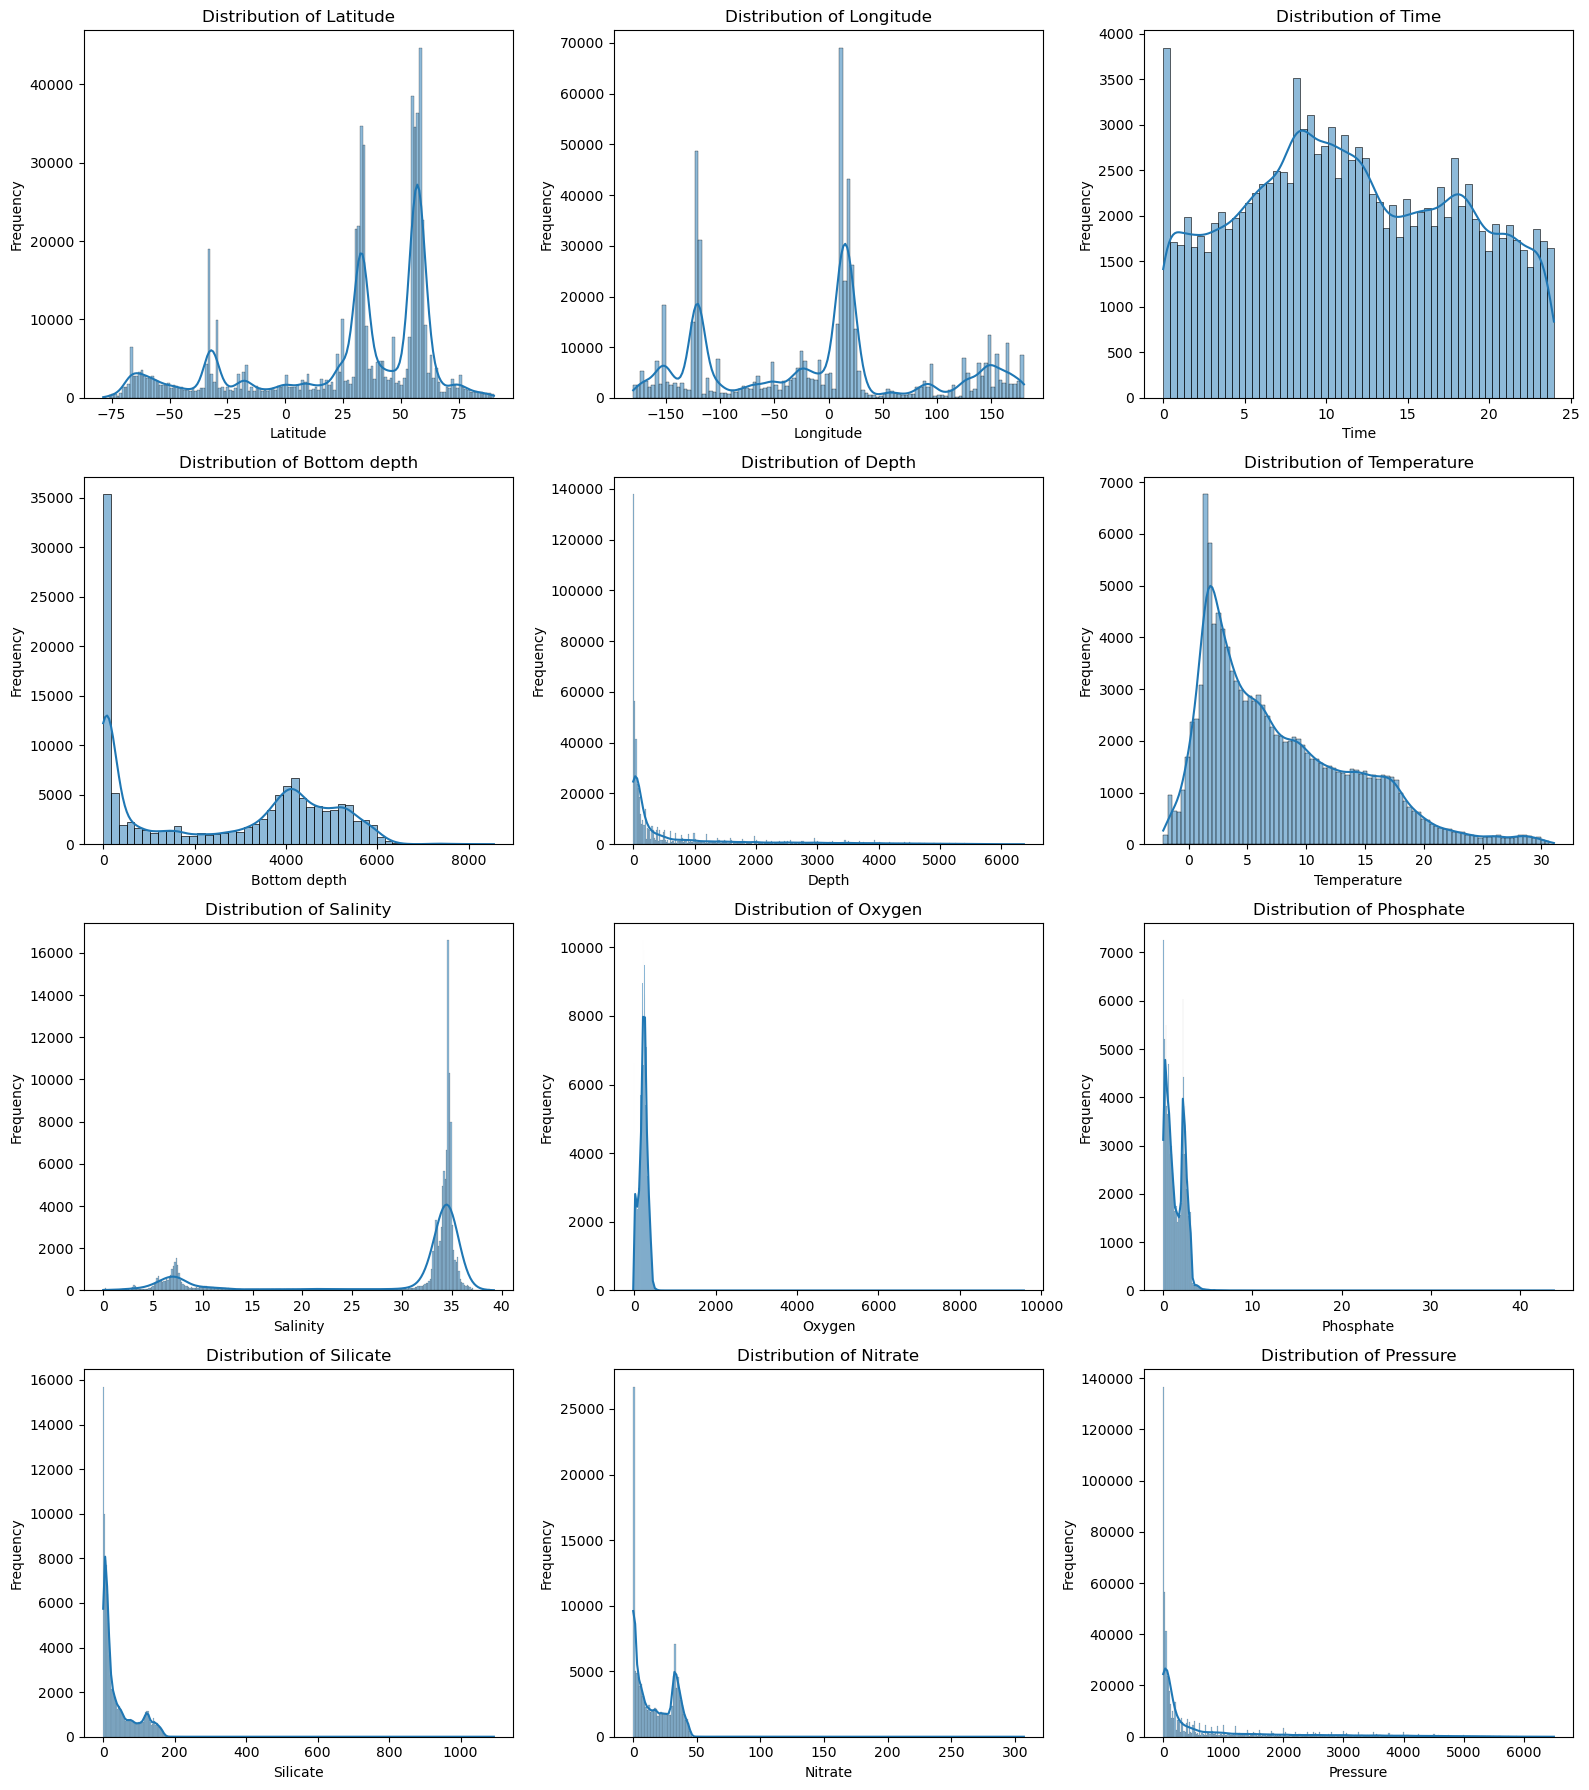

In [63]:
histogram_cols = ['Temperature', 'Salinity', 'Oxygen', 'Chlorophyl', 'Pressure', 'Phosphate', 'Silicate', 'Nitrate']
def plot_numeric_histograms(df, numeric_cols, figsize=(16, 3*math.ceil(len(numeric_cols)/3))):
   """
   Create histograms for numeric columns arranged in subplots.
   Uses clean display names for titles and labels.

   Parameters:
   -----------
   df : pandas.DataFrame
       The dataframe containing the numeric columns to plot
   numeric_cols : list
       List of numeric column names to create histograms for
   figsize : tuple, optional
       Figure size as (width, height) in inches, default dynamically calculated based on column count
   """
   # Calculate layout dimensions
   n_plots = len(numeric_cols)
   n_cols = 3  # Show 2 plots per row
   n_rows = math.ceil(n_plots / n_cols)

   # Create the figure and subplots
   fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
   axes = axes.flatten() if n_rows * n_cols > 1 else [axes]  # Flatten if multiple plots

   # Create a histogram for each numeric column
   for i, col in enumerate(numeric_cols):
       if i < len(axes):  # Ensure we don't exceed the number of subplots
           # Plot histogram with KDE (Kernel Density Estimation) curve
           sns.histplot(df[col], kde=True, ax=axes[i])
           axes[i].set_title(f'Distribution of {col}')
           axes[i].set_xlabel(col)
           axes[i].set_ylabel('Frequency')

   # Hide any unused subplots if odd number of columns
   for j in range(i+1, len(axes)):
       axes[j].set_visible(False)

   # Adjust spacing between subplots for better readability
   plt.subplots_adjust(wspace=0.3, hspace=0.4)
   plt.tight_layout()
   plt.show()

# Generate histograms for all numeric variables to visualize their distributions
histogram_cols = [col for col in numeric_cols if col not in ['CAST', 'Year', 'Month', 'Day']]
plot_numeric_histograms(df, histogram_cols)


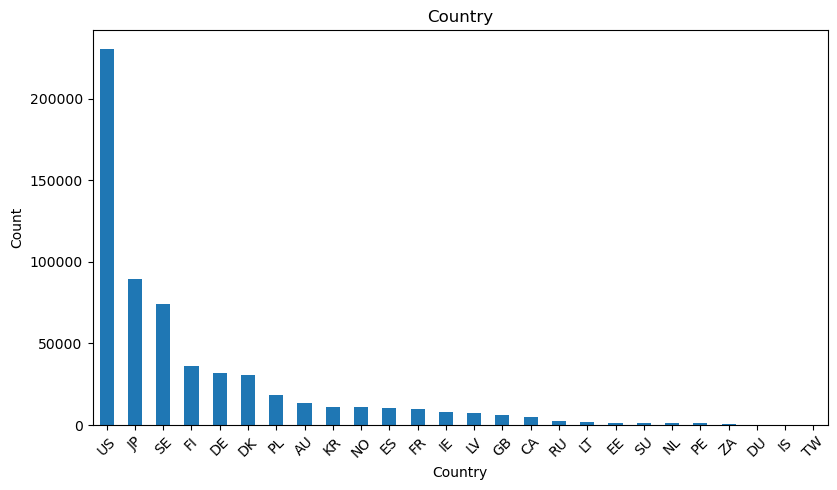

In [64]:
def plot_categorical_bars(df, categorical_cols, figsize=(16, 5*math.ceil(len(categorical_cols)/2))):
    """
    Create stacked bar charts for categorical columns arranged in subplots.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the categorical columns to plot
    categorical_cols : list
        List of categorical column names to create bar charts for
    figsize : tuple, optional
        Figure size as (width, height) in inches, default dynamically calculated based on column count
    """

    # Calculate layout dimensions
    n_plots = len(categorical_cols)
    n_cols = 2  # Show 2 plots per row
    n_rows = math.ceil(n_plots / n_cols)

    # Create the figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]  # Flatten if multiple plots

    # Create a stacked bar chart for each categorical column
    for i, col in enumerate(categorical_cols):
        if i < len(axes):  # Ensure we don't exceed the number of subplots

            value_counts = df[col].value_counts()

            # Plot bar chart
            value_counts.plot(kind='bar', ax=axes[i])
            axes[i].set_title(f'{col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.tight_layout()
    plt.show()

plot_categorical_bars(df, categorical_cols)

### Geographic Coverage

In [65]:
# Get unique coordinates
unique_df = df[['Latitude', 'Longitude']].drop_duplicates()
total_points = len(df)
unique_locations = len(unique_df)


print(f"Total data points: {total_points:,}")
print(f"Unique locations: {unique_locations:,}")
print(f"Duplicate locations: {total_points - unique_locations:,}")
print(f"Percentage unique: {(unique_locations/total_points)*100:.2f}%")

# Scatter plot unique coordinates
fig = px.scatter_geo(unique_df,
                     lat='Latitude',
                     lon='Longitude',
                     title='WOD Data Coverage Map',
                     projection='natural earth',
                     opacity=0.5)

fig.update_traces(marker=dict(size=3, color='blue'))

fig.update_geos(
    showland=True,
    landcolor='lightgray',
    showocean=True,
    oceancolor='lightblue'
)

fig.show()

Total data points: 602,900
Unique locations: 23,472
Duplicate locations: 579,428
Percentage unique: 3.89%


### Correlation Analysis

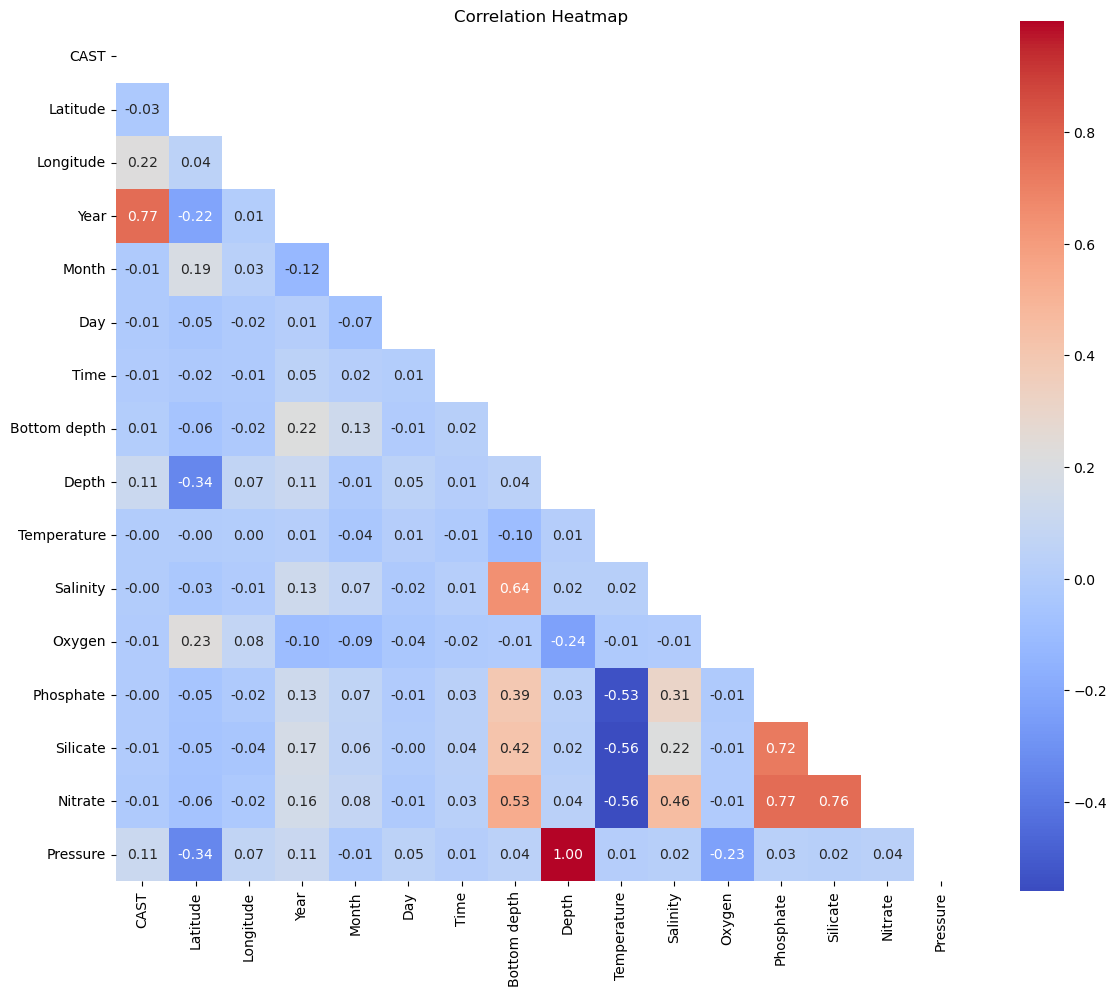

In [66]:
# Generate a correlation heatmap to visualize relationships between numeric variables
plt.figure(figsize=(12, 10))  # Set figure size for better readability

# Calculate the correlation matrix for numeric variables
corr = df[numeric_cols].corr()

# Create a mask for the upper triangle to avoid redundant display
# triu = upper triangle, ones_like creates a matrix of 1s with same shape as corr
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate the heatmap with annotations
sns.heatmap(
   corr,                  # Correlation matrix
   mask=mask,             # Apply mask to show only lower triangle
   annot=True,            # Show correlation values on cells
   fmt=".2f",             # Format for correlation values (2 decimal places)
   cmap="coolwarm",       # Color scheme (blue=negative, red=positive)
   square=True            # Ensure cells are square-shaped
)

plt.title("Correlation Heatmap")  # Add title
plt.tight_layout()               # Adjust spacing for better display
plt.show()                       # Display the heatmap

In [67]:
# Get correlations with oxygen, sorted by strength
oxygen_corr = df[numeric_cols].corr()['Oxygen'].drop('Oxygen')
oxygen_corr_sorted = oxygen_corr.abs().sort_values(ascending=False)

print("Variables correlation with Oxygen:")
for var in oxygen_corr_sorted.index:
    print(f"{var}: {oxygen_corr[var]:.3f}")

Variables correlation with Oxygen:
Depth: -0.236
Pressure: -0.235
Latitude: 0.230
Year: -0.101
Month: -0.086
Longitude: 0.080
Day: -0.038
Time: -0.016
Temperature: -0.011
Phosphate: -0.011
Bottom depth: -0.008
Silicate: -0.007
CAST: -0.007
Nitrate: -0.007
Salinity: -0.005
